<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/security_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 治安・防災スコア
- input
    - crime_score.csv
        - 犯罪件数
    - hazard_master.csv
        - ハザード危険度
    - police_master.csv
        - 警察署・交番
    - traffic_accident_master.csv
        - 交通事故件数
- output
    - security_score.csv
        - 治安防犯スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 地理マスタ

In [5]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [6]:
type_list = []

### 犯罪スコア

In [7]:
df_crime_score = pd.read_csv(os.path.join(DIR_NAME, 'crime_score.csv'))
print(df_crime_score.shape)

(3145, 7)


In [8]:
df_crime_score.head()

,town_id,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,犯罪スコア
0,101003,1.0,23.0,0.0,136.0,82.0,0.19
1,101004,0.0,1.0,0.0,22.0,17.0,1.63
2,101005,0.0,3.0,0.0,13.0,125.0,1.09
3,101007,1.0,8.0,3.0,18.0,6.0,0.08
4,101008,0.0,9.0,0.0,12.0,3.0,1.29


### 防災スコア

In [9]:
df_hazard_master = pd.read_csv(os.path.join(DIR_NAME, 'hazard_master.csv'))
print(df_hazard_master.shape)

(3145, 14)


In [10]:
df_hazard_master.head()

,town_id,市区町村名,町丁目,地盤分類,建物倒壊危険度危険量（棟/ha）,建物倒壊危険度順位,建物倒壊危険度ランク,火災危険度危険量（棟/ha）,火災危険度順位,火災危険度ランク,災害時活動困難度困難係数,総合危険度危険量（棟/ha）,総合危険度順位,総合危険度ランク
0,101003,千代田区,丸の内１丁目,沖積低地2,0.55,4205.0,1,0.0,5086.0,1,0.10,0.05,4498.0,1
1,101004,千代田区,丸の内２丁目,沖積低地3,0.07,4990.0,1,0.0,5029.0,1,0.09,0.01,5059.0,1
2,101005,千代田区,丸の内３丁目,沖積低地2,0.38,4459.0,1,0.0,5078.0,1,0.10,0.04,4679.0,1
3,101007,千代田区,大手町１丁目,沖積低地3,0.09,4957.0,1,0.0,5083.0,1,0.09,0.01,5033.0,1
4,101008,千代田区,大手町２丁目,沖積低地2,0.19,4775.0,1,0.0,5093.0,1,0.13,0.02,4807.0,1


### 警察署マスタ

In [11]:
df_police_master = pd.read_csv(os.path.join(DIR_NAME, 'police_master.csv'))
print(df_police_master.shape)

(943, 5)


In [12]:
df_police_master.head()

,名称,住所,緯度,経度,施設分類
0,蒲田警察署 西六郷交番,大田区西六郷２丁目３７−５,35.549362,139.707030,交番
1,蒲田警察署 東六郷交番,大田区東六郷３丁目６−２,35.545629,139.713127,交番
2,蒲田警察署 雑色交番,大田区東六郷２丁目１８−８,35.548965,139.715621,交番
3,幸警察署 河原町交番,川崎市幸区河原町１−３１ 幸警察署河原町交番,35.541822,139.694594,交番
4,蒲田警察署 西六郷一丁目地域安全センター,大田区西六郷１丁目４−１５,35.555122,139.709305,交番


In [13]:
police_type = list(df_police_master['施設分類'].unique())
type_list += police_type

### 交通事故マスタ

In [14]:
df_traffic_accident = pd.read_csv(os.path.join(DIR_NAME, 'traffic_accident_master.csv'))
print(df_traffic_accident.shape)

(19201, 6)


In [15]:
df_traffic_accident['内容'] = df_traffic_accident['内容'] + '事故'
df_traffic_accident = df_traffic_accident.rename(columns={'内容': '施設分類'})
df_traffic_accident.head()

,施設分類,種別,死者数,負傷者数,緯度,経度
0,負傷事故,車両相互,0,1,35.680171,139.782159
1,負傷事故,車両相互,0,1,35.657842,139.702199
2,負傷事故,車両相互,0,1,35.583598,139.755518
3,負傷事故,車両相互,0,2,35.551597,139.745439
4,負傷事故,車両相互,0,2,35.751811,139.709833


In [16]:
accident_type = list(df_traffic_accident['施設分類'].unique())
type_list += accident_type

In [17]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.02) &    # 約2km以内
            ((_df_cat['経度'] - lon).abs() < 0.02)      # 約2km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [18]:
df_security_master = pd.concat([
    df_police_master,
    df_traffic_accident,
]).reset_index(drop=True)
print(df_security_master.shape)

(20144, 8)


In [19]:
%%time
radius = 0.5    # 0.5km以内の数
for _type in type_list:
    df_geo_master[f'{_type}(数)'] = get_value_of_nearest_facility(df_geo_master, df_security_master, _type, 'count', radius)
    print(_type)

交番
警察署
負傷事故
死亡事故
CPU times: user 1min 9s, sys: 705 ms, total: 1min 10s
Wall time: 1min 30s


In [20]:
df_hazard_master.columns

Index(['town_id', '市区町村名', '町丁目', '地盤分類', '建物倒壊危険度危険量（棟/ha）', '建物倒壊危険度順位',
       '建物倒壊危険度ランク', '火災危険度危険量（棟/ha）', '火災危険度順位', '火災危険度ランク', '災害時活動困難度困難係数',
       '総合危険度危険量（棟/ha）', '総合危険度順位', '総合危険度ランク'],
      dtype='object')

In [21]:
df_security_score = pd.merge(
    df_geo_master,
    df_crime_score,
    on='town_id', how='left'
)
df_security_score = pd.merge(
    df_security_score,
    df_hazard_master[['town_id', '建物倒壊危険度ランク', '火災危険度ランク', '総合危険度ランク']],
    on='town_id', how='left'
)
print(df_security_score.shape)

(3145, 19)


In [22]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

In [23]:
df_security_score['警察スコア'] = rank_score(df_security_score['交番(数)'] + df_security_score['警察署(数)'] * 3).round(2)
df_security_score['交通事故スコア'] = rank_score((-1) * (df_security_score['負傷事故(数)'] + df_security_score['死亡事故(数)'] * 30)).round(2)
df_security_score['防災スコア'] = 6 - df_security_score['総合危険度ランク']
df_security_score.loc[df_security_score['防災スコア'] == 6, '防災スコア'] = 2

In [24]:
feature_list = [col for col in df_security_score.columns if col.endswith(')')] + ['犯罪スコア', '防災スコア', '警察スコア', '交通事故スコア']

交番(数)


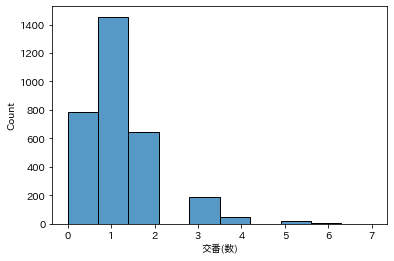

警察署(数)


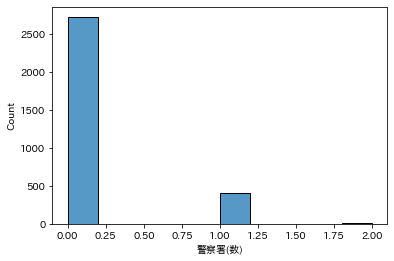

負傷事故(数)


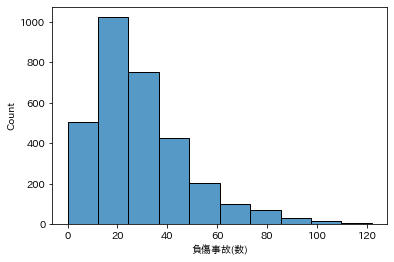

死亡事故(数)


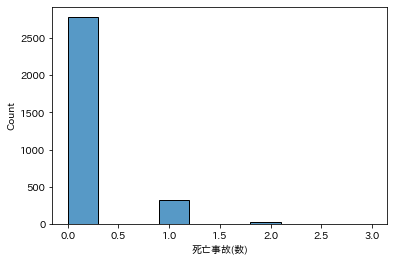

犯罪スコア


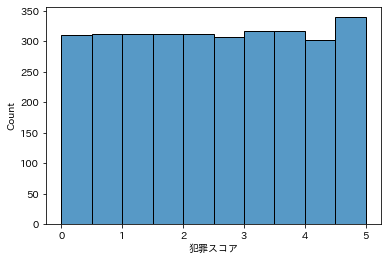

防災スコア


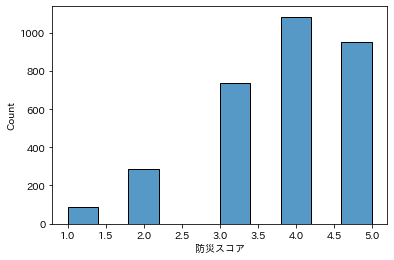

警察スコア


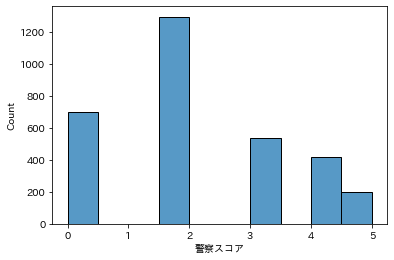

交通事故スコア


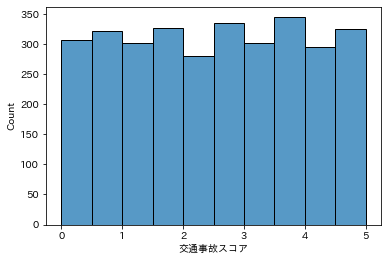

In [25]:
for feature in feature_list:
    print(feature)
    sns.histplot(df_security_score[feature], bins=10)
    plt.show()

In [26]:
def plot_score(df_master, score_name, sr_source=None):
    if sr_source is not None:
        sns.histplot(sr_source, bins=20)
        plt.show()
    sns.histplot(df_master[score_name], bins=20)
    plt.show()
    print(df_master[score_name].describe())

In [27]:
score_name = '治安防犯スコア'
score_list = [
    df_security_score['犯罪スコア'] * 1.0,
    df_security_score['防災スコア'] * 0.5,
    df_security_score['警察スコア'] * 0.5,
    df_security_score['交通事故スコア'] * 0.7,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_security_score[score_name] = rank_score(_tmp_score).round(2)

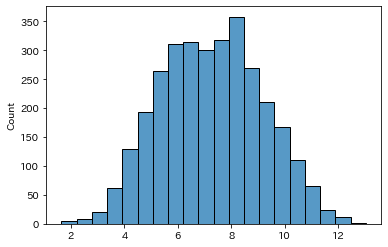

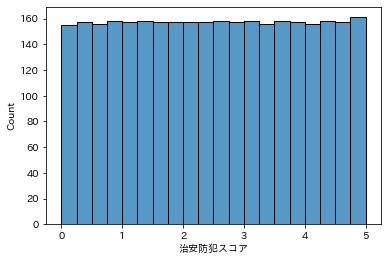

count    3145.000000
mean        2.500051
std         1.444095
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 治安防犯スコア, dtype: float64


In [28]:
plot_score(df_security_score, score_name, _tmp_score)

In [29]:
df_security_score.iloc[995:1000]

,town_id,市区町村名,町名,町丁目,緯度,経度,交番(数),警察署(数),負傷事故(数),死亡事故(数),凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,犯罪スコア,建物倒壊危険度ランク,火災危険度ランク,総合危険度ランク,警察スコア,交通事故スコア,防災スコア,治安防犯スコア
995,109093,品川区,小山,小山２丁目,35.620939,139.708842,0,0,38,1,0.0,1.0,0.0,8.0,6.0,2.29,3,4,4,0.00,0.44,2,0.07
996,109094,品川区,小山,小山３丁目,35.619846,139.705490,2,0,41,1,0.0,1.0,3.0,37.0,5.0,0.75,2,2,2,3.42,0.40,4,0.47
997,109095,品川区,小山,小山４丁目,35.618303,139.703071,2,0,46,1,0.0,3.0,1.0,9.0,3.0,0.87,3,3,3,3.42,0.32,3,0.26
998,109096,品川区,小山,小山５丁目,35.616420,139.701730,2,0,40,0,0.0,1.0,0.0,5.0,4.0,2.82,2,2,2,3.42,1.45,4,2.74
999,109097,品川区,小山,小山６丁目,35.614066,139.698612,2,0,30,0,0.0,5.0,0.0,7.0,3.0,1.61,3,4,3,3.42,2.21,3,1.74


In [30]:
output_score_file = 'security_score.csv'
df_security_score.drop(columns=['市区町村名', '町名', '町丁目', '緯度', '経度']).to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

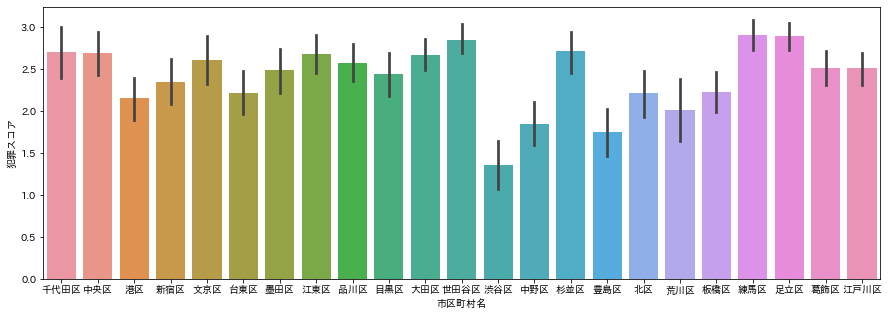

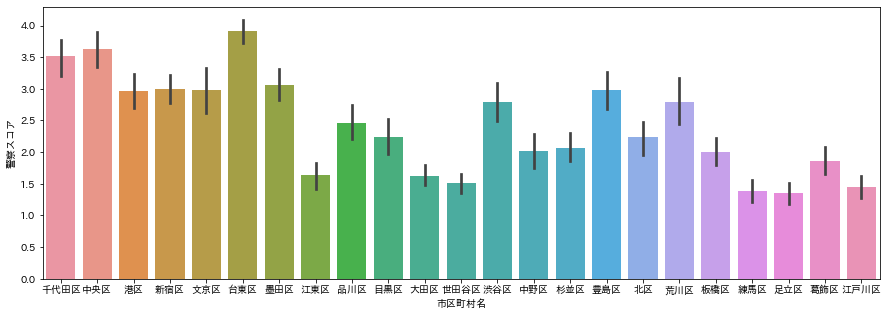

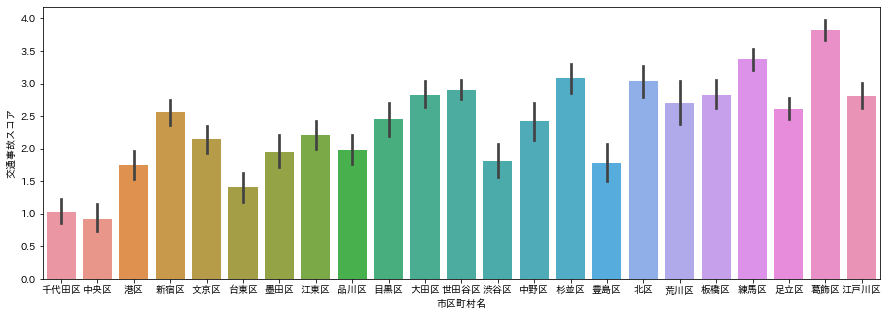

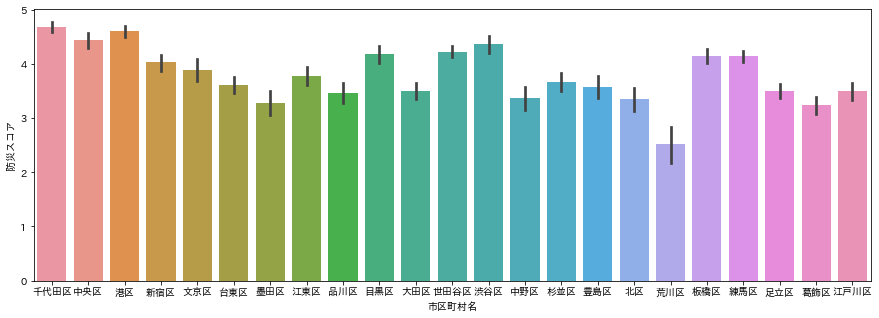

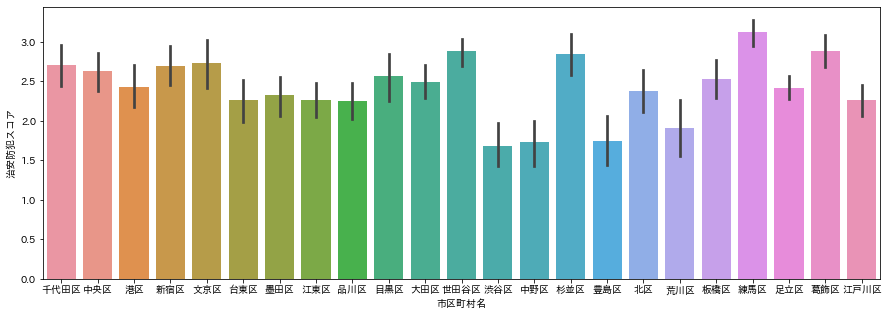

In [31]:
score_name_list = [col for col in df_security_score.columns if col.endswith('スコア')]
for score in score_name_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score, data=df_security_score)
    plt.show()